# Data Stream Processing - Project 3 : Ideas for Extension (20%)

In [ ]:
# Import librairies.
import glob
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from itertools import groupby


## The data

In [ ]:
# Get files
DATAPATH =  "../data/custom_no_streaming_8/folder_2"
files = glob.glob(rf"{DATAPATH}/*")
files

In [ ]:
# Read anomaly files and concatenate dataframes
dfs = []
for file in files[:-1]:
    df = pd.read_csv(file)
    # Extract the filename without the parent folder path and extension
    filename = file.split('\\')[-1].split('.')[0]
    # Add a new column "anomaly_type" with the extracted filename
    df.insert(1, column="trace_id", value=filename)
    df.rename({"Unnamed: 0": "time"}, axis=1, inplace=True)
    dfs.append(df)

# Concatenate all dataframes except labels.csv
anomaly_df = pd.concat(dfs)
anomaly_df

# Rename values in the "anomaly_type" column based on the specified mapping
mapping = {
    "1_3": "bursty_input",
    "1_4": "bursty_input",
    "2_3": "stalled_input",
    "2_4": "stalled_input",
    "3_3": "cpu_contention",
    "3_4": "cpu_contention"
}
anomaly_df.insert(2, column="anomaly_type", value=anomaly_df['trace_id'].replace(mapping))

anomaly_df.head(5)

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, RepeatVector
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

# Charger les données
# Assurez-vous que votre fichier CSV est correctement formaté et accessible
df = anomaly_df[anomaly_df['trace_id'] == '1_3'].copy()

# Sélectionner les colonnes numériques pertinentes (exclure 'time' et 'trace_id')
cols = df.columns[3:]

# Normaliser les données
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df[cols])

# Reshape data pour LSTM [samples, time steps, features]
timesteps = 1  # Vous pouvez ajuster cela selon votre séquence de temps
features = len(cols)
data = df_scaled.reshape(df_scaled.shape[0], timesteps, features)

# Construction de l'autoencodeur LSTM
inputs = Input(shape=(timesteps, features))
encoded = LSTM(10, return_sequences=False)(inputs)
decoded = RepeatVector(timesteps)(encoded)
decoded = LSTM(features, return_sequences=True)(decoded)

autoencoder = Model(inputs, decoded)
autoencoder.compile(optimizer=Adam(learning_rate=0.001), loss='mse')

# Entraîner le modèle
autoencoder.fit(data, data, epochs=20, batch_size=128, validation_split=0.2, shuffle=True)

# Prédire les données reconstruites
predictions = autoencoder.predict(data)

# Calculer l'erreur de reconstruction
mse = np.mean(np.power(data - predictions, 2), axis=1)
error_df = pd.DataFrame({'Reconstruction_error': mse[:,0]})

# Identifier les anomalies (Vous pouvez définir un seuil d'erreur)
threshold = np.percentile(error_df.Reconstruction_error.values, 95)
anomalies = error_df[error_df.Reconstruction_error > threshold]


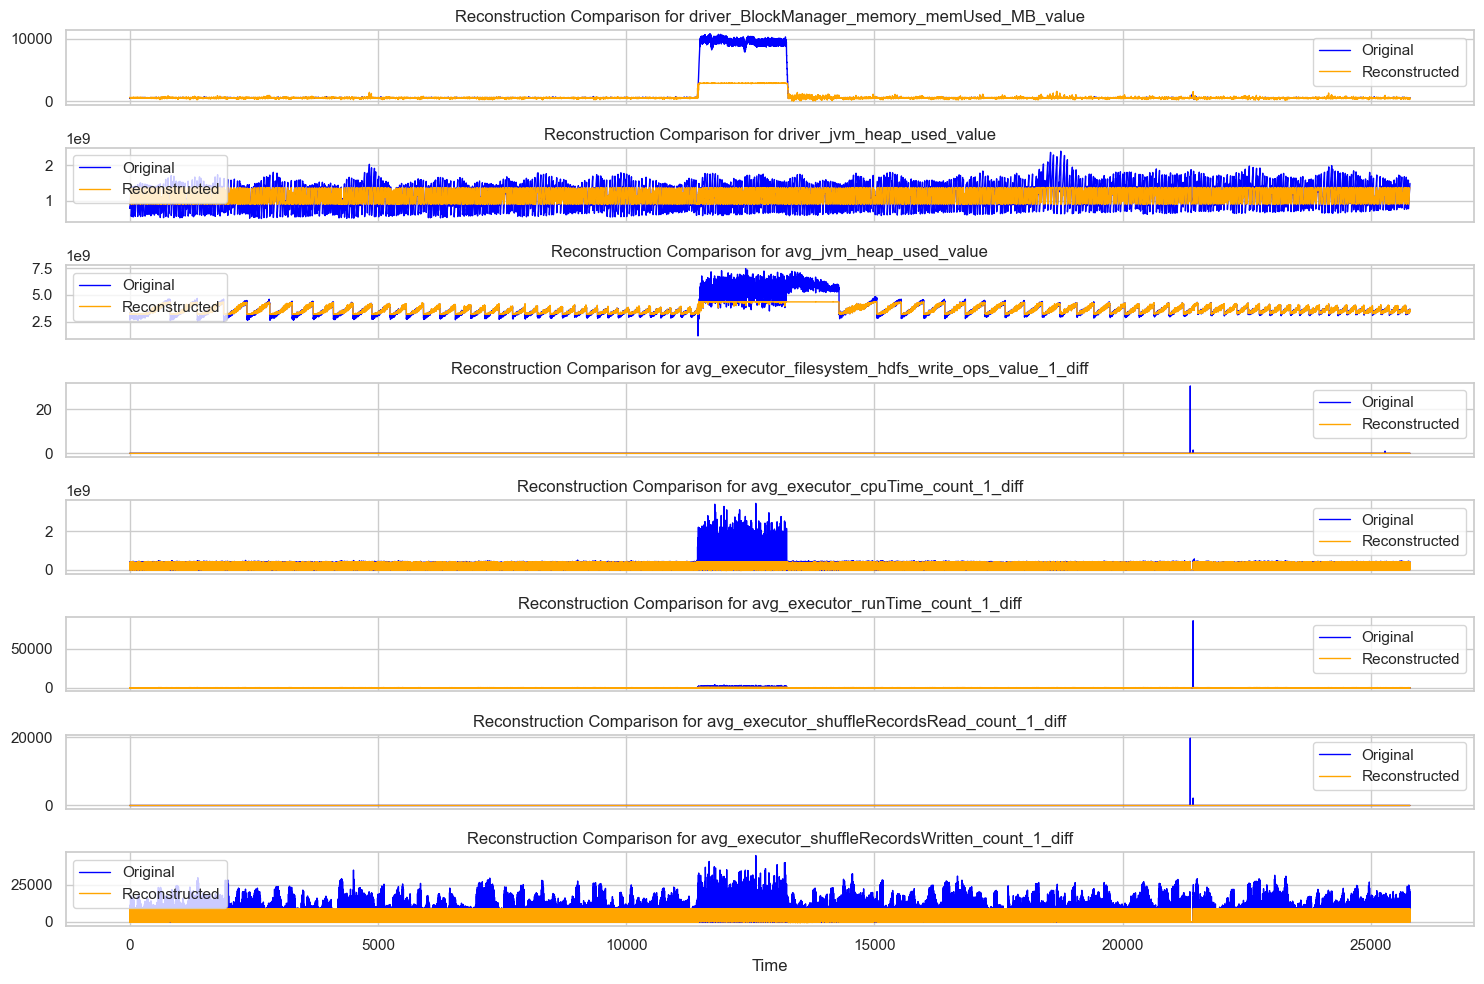

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Rescale predictions back to original scale
predictions_rescaled = scaler.inverse_transform(predictions.reshape(predictions.shape[0], features))

# Set Seaborn style
sns.set(style='whitegrid')

# Number of variables (excluding 'time' and 'trace_id')
num_vars = len(cols)

# Create subplots
# add 3 columns for the time, trace_id, and anomaly_type columns


fig, axes = plt.subplots(num_vars, figsize=(15, 10), sharex=True)

for i, col in enumerate(cols):
    # Original Data
    axes[i].plot(df['time'], df[col], label='Original', color='blue', linewidth=1)

    # Reconstructed Data
    axes[i].plot(df['time'], predictions_rescaled[:, i], label='Reconstructed', color='orange', linewidth=1)

    # Titles and Labels
    axes[i].set_title(f'Reconstruction Comparison for {col}')
    #axes[i].set_ylabel(col)
    axes[i].legend()

# Set common X label
axes[-1].set_xlabel('Time')

# Adjust layout for better readability
plt.tight_layout()
plt.show()


C:\Users\choho\AppData\Local\Temp\ipykernel_12404\2435052025.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  anomalies['time'] = anomalies.index


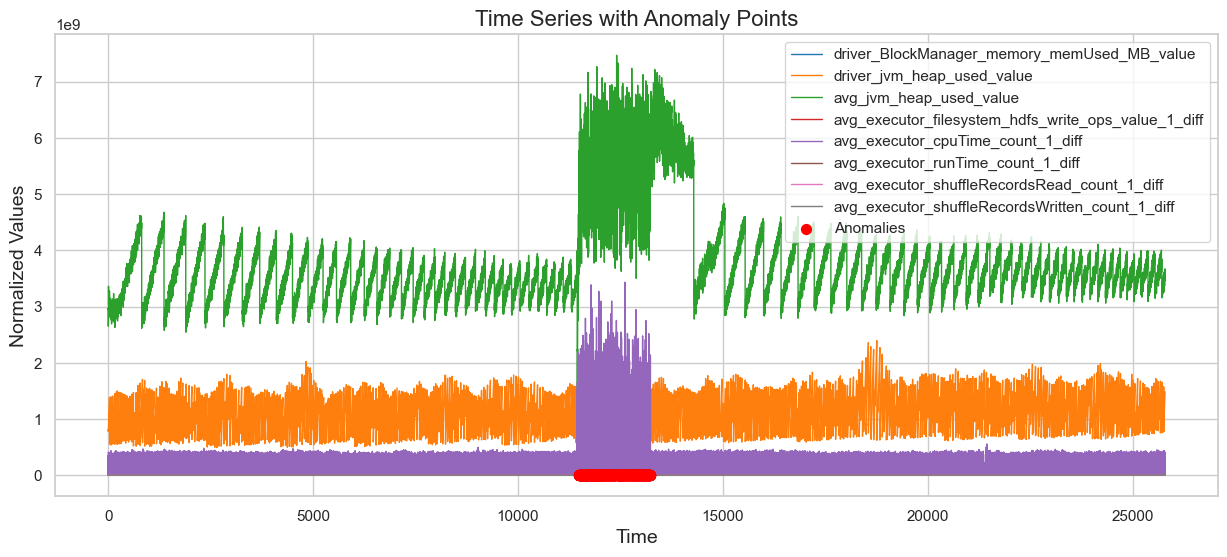

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

# Ajouter la colonne 'time' pour référence temporelle
anomalies['time'] = anomalies.index

# Set the Seaborn style for better aesthetics
sns.set(style='whitegrid')

# Define color palette for the time series
colors = sns.color_palette('tab10', len(cols))

# Create a figure and axis for the plot
plt.figure(figsize=(15, 6))
ax = plt.gca()

# Plot each time series with a thinner line
for i, col in enumerate(cols):
    ax.plot(df['time'], df[col], color=colors[i], linewidth=1, label=col)

# Highlight anomaly points with red color
ax.scatter(anomalies['time'], df.loc[anomalies.index, cols[0]], color='red', s=50, label='Anomalies', zorder=5)

# Set title and labels with appropriate font sizes
ax.set_title('Time Series with Anomaly Points', fontsize=16)
ax.set_xlabel('Time', fontsize=14)
ax.set_ylabel('Normalized Values', fontsize=14)

# Place the legend in the upper right corner of the plot
ax.legend(loc='upper right', frameon=True)

# Display the plot
plt.show()
